In [1]:
import pickle
def save_data(name, data):
    with open(name, 'wb') as f:
        pickle.dump(data, f)
        f.close()
def load_data(name):
    return pickle.load(open(name, 'rb'))

In [2]:
X_train = load_data('./bert_X_train_padded.pickle')
y_train = load_data('./bert_y_train.pickle')
X_test = load_data('./bert_X_test_padded.pickle')
y_test = load_data('./bert_y_test.pickle')
X_val = load_data('./bert_X_val_padded.pickle')
y_val = load_data('./bert_y_val.pickle')

### BERT

In [3]:
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.layers import Dropout, Input, Dense
from transformers import DistilBertTokenizer, TFAutoModel, AdamWeightDecay
from tensorflow_addons.metrics import F1Score
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
max_len = 45
pretrained_model = TFAutoModel.from_pretrained(pretrained_model_name_or_path='distilbert-base-uncased')

# Transfer Learning -> using transfer learning, we can use a pre-trained model in a customized way.
input_layer = Input(shape=(max_len,), dtype=tf.int32)
# we utilize a pre-trained transformer model to process input sequences or texts
transformer_layers = pretrained_model(input_layer)[0] 
# The CLS variable stores the representation of the [CLS] token, which is typically used as a aggregate representation of the entire input sequence.
CLS = transformer_layers[:, 0, :] 
drop1 = Dropout(.8)(CLS)
output = Dense(10, activation='softmax')(drop1)

bert_tf = Model(inputs=input_layer, outputs=output)
bert_tf.compile(
    loss = 'categorical_crossentropy',
    optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01),
    metrics = F1Score(num_classes=10, average='macro')
)

bert_tf.summary()

/Users/yaoyao/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are 

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 45)]              0         
                                                                 
 tf_distil_bert_model (TFDis  TFBaseModelOutput(last_h  66362880 
 tilBertModel)               idden_state=(None, 45, 7            
                             68),                                
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                          

In [4]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
EPOCHS = 2
BATCH_SIZE = 32 * 4 # The number of input sequences in each batch
STEPS_PER_EPOCH = X_train.shape[0] // BATCH_SIZE # The numebr of batches
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('./model/bert_weights.h5', monitor='val_f1_score', save_best_only=True) 
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

history = bert_tf.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr, early_stopping, model_checkpoint]
)

Epoch 1/2


2023-10-09 20:17:31.643757: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


9/9 [==============================] - 75s 8s/step - loss: 2.6092 - f1_score: 0.0872 - val_loss: 2.2859 - val_f1_score: 0.0255 - lr: 2.0000e-05
Epoch 2/2
9/9 [==============================] - 75s 9s/step - loss: 2.5816 - f1_score: 0.0874 - val_loss: 2.2670 - val_f1_score: 0.0582 - lr: 2.0000e-05


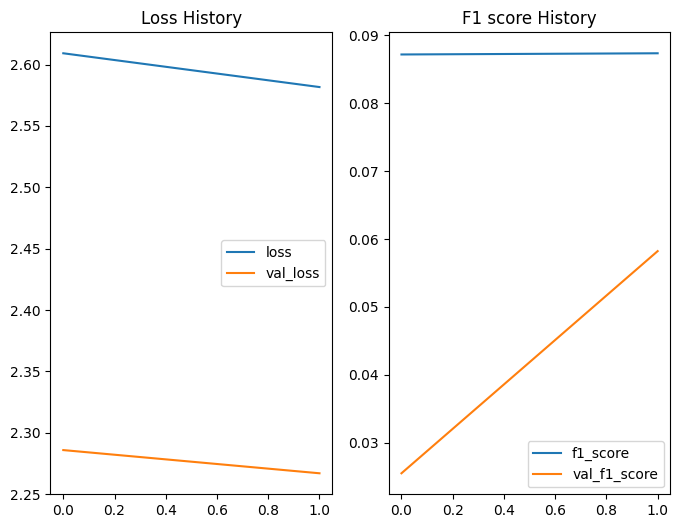

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss History')
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'], label='f1_score')
plt.plot(history.history['val_f1_score'], label='val_f1_score')
plt.legend()
plt.title('F1 score History')
plt.show()

In [6]:
import numpy as np
y_pred = bert_tf.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1) # convert the One-Hot-Encoded vecotrs to a single vector
y_pred_class

73/73 [==============================] - 28s 371ms/step


array([5, 5, 5, ..., 1, 5, 5])

In [7]:
y_pred

array([[0.08089184, 0.14896509, 0.06106955, ..., 0.07659248, 0.11953514,
        0.07273828],
       [0.07151133, 0.12566648, 0.05736444, ..., 0.07838004, 0.12965776,
        0.0700222 ],
       [0.06889699, 0.14156237, 0.05568785, ..., 0.06964198, 0.10829942,
        0.06219419],
       ...,
       [0.08060089, 0.15854014, 0.07532825, ..., 0.07399785, 0.13001172,
        0.0823747 ],
       [0.06865384, 0.12851238, 0.05650035, ..., 0.0747931 , 0.11241422,
        0.09148761],
       [0.07098819, 0.10649643, 0.05967065, ..., 0.09117531, 0.1446909 ,
        0.07382732]], dtype=float32)

In [8]:
y_test_class = np.argmax(y_test, axis=1)
y_test_class

array([8, 0, 1, ..., 6, 7, 6])

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true=y_test_class, y_pred=y_pred_class))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       161
           1       0.25      0.38      0.30       254
           2       0.00      0.00      0.00       138
           3       0.00      0.00      0.00       239
           4       0.17      0.01      0.03       285
           5       0.15      0.90      0.26       315
           6       0.00      0.00      0.00       214
           7       0.00      0.00      0.00       219
           8       0.25      0.01      0.03       299
           9       0.00      0.00      0.00       181

    accuracy                           0.17      2305
   macro avg       0.08      0.13      0.06      2305
weighted avg       0.10      0.17      0.07      2305



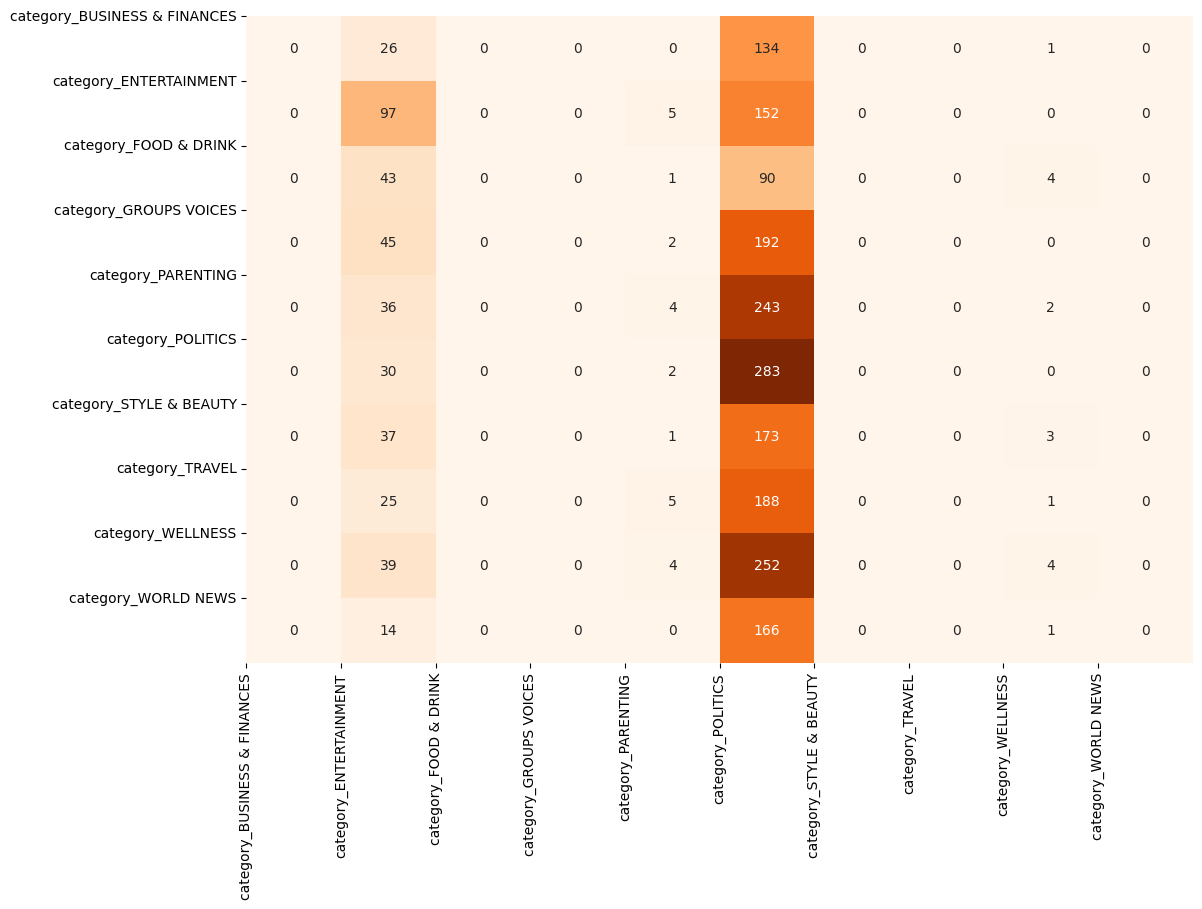

In [10]:
import seaborn as sns
classes_name = ['category_BUSINESS & FINANCES',
 'category_ENTERTAINMENT',
 'category_FOOD & DRINK',
 'category_GROUPS VOICES',
 'category_PARENTING',
 'category_POLITICS',
 'category_STYLE & BEAUTY',
 'category_TRAVEL',
 'category_WELLNESS',
 'category_WORLD NEWS']
conf_matrix = confusion_matrix(y_true=y_test_class, y_pred=y_pred_class)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', cbar=False);
plt.tight_layout();
plt.xticks(range(10), classes_name, rotation=90);
plt.yticks(range(10), classes_name, rotation=360);

### K-means

In [11]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


Text(0.5, 1.0, 'Raw Data')

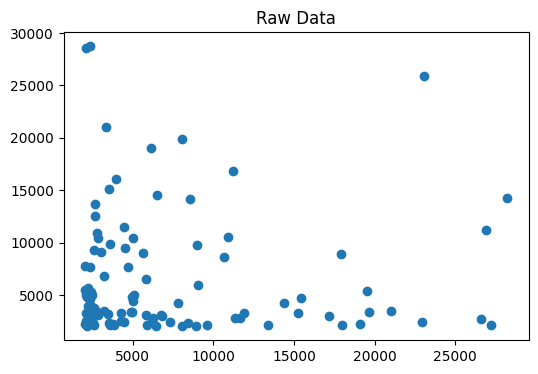

In [12]:
### plot raw data
plt.figure(figsize=(6, 4))
plt.scatter(X_test[:100, 2], X_test[:100, 4], cmap='viridis')
plt.title('Raw Data')

In [13]:
scaler = StandardScaler()
X_scalared = scaler.fit_transform(X_train)
pca = PCA()
pca.fit(X_scalared)

PCA()

Text(0, 0.5, 'Cumulative Explained Variance Ratio')

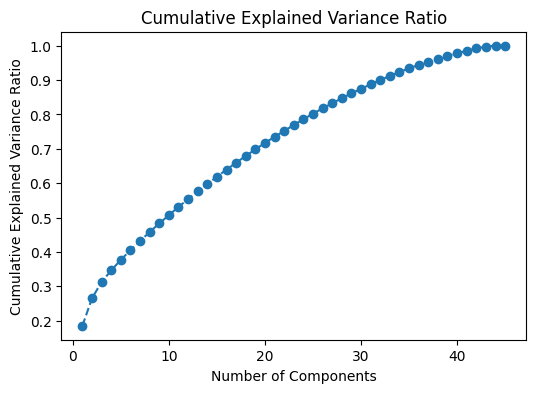

In [14]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, max_len+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')

In [15]:
pca = PCA(n_components=2)
y_train_class = np.argmax(y_train, axis=1)
pca.fit(X_scalared, y_train_class)

PCA(n_components=2)

In [16]:
pca.transform(X_scalared)

array([[-1.50450287,  1.0373074 ],
       [-1.75749746,  1.43782623],
       [ 4.68871587, -4.30633536],
       ...,
       [-1.72917403,  1.52087889],
       [-0.56154325, -0.83602797],
       [-0.98384585,  0.08073769]])

In [17]:
scores_pca = pca.transform(X_scalared)

In [18]:
# k-means with pca
wcss = []
# test for at most 20 clusters
for i in range(1, 21):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

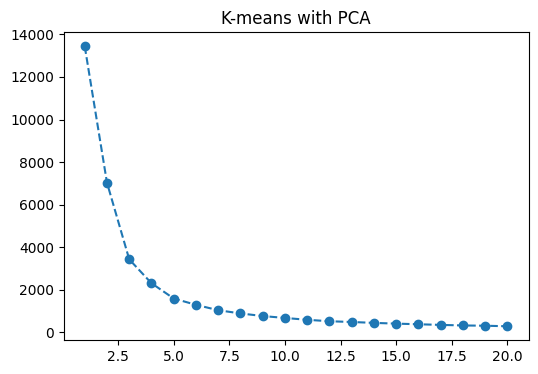

In [19]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
plt.title('K-means with PCA')
plt.show()

In [20]:
kmeans_pca = KMeans(n_clusters=10, init='k-means++', random_state=42)

kmeans_pca.fit(scores_pca, y=y_train_class)

KMeans(n_clusters=10, random_state=42)

In [27]:
X_test_scalared = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scalared)

In [28]:
y_pred = kmeans_pca.predict(X_test_pca)

In [29]:
y_pred

array([6, 6, 3, ..., 1, 7, 5], dtype=int32)

In [30]:
k_mean_acc = np.sum(y_pred == y_test_class) / len(y_test_class)
k_mean_acc

0.10976138828633406

In [31]:
print(classification_report(y_true=y_test_class, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.11      0.06      0.08       161
           1       0.19      0.39      0.25       254
           2       0.00      0.00      0.00       138
           3       0.08      0.07      0.07       239
           4       0.20      0.01      0.02       285
           5       0.11      0.02      0.03       315
           6       0.05      0.11      0.07       214
           7       0.12      0.19      0.14       219
           8       0.12      0.17      0.14       299
           9       0.06      0.03      0.04       181

    accuracy                           0.11      2305
   macro avg       0.10      0.10      0.08      2305
weighted avg       0.11      0.11      0.09      2305



In [32]:
import pandas as pd
df_x = pd.DataFrame(X_train)
df_segm_pca_kmeans = pd.concat([df_x.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_segm_pca_kmeans.columns.values[-2:] = [45, 46]
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_


In [33]:
df_segm_pca_kmeans.columns.values

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 'Segment K-means PCA'],
      dtype=object)

In [34]:
df_segm_pca_kmeans['segment'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0: 'first', 1: 'second', 2: 'third', 3: 'fourth', 4: 'fifth', 5: 'sixth', 6: 'seventh', 7: 'eighth', 8: 'ninth', 9: 'tenth'})

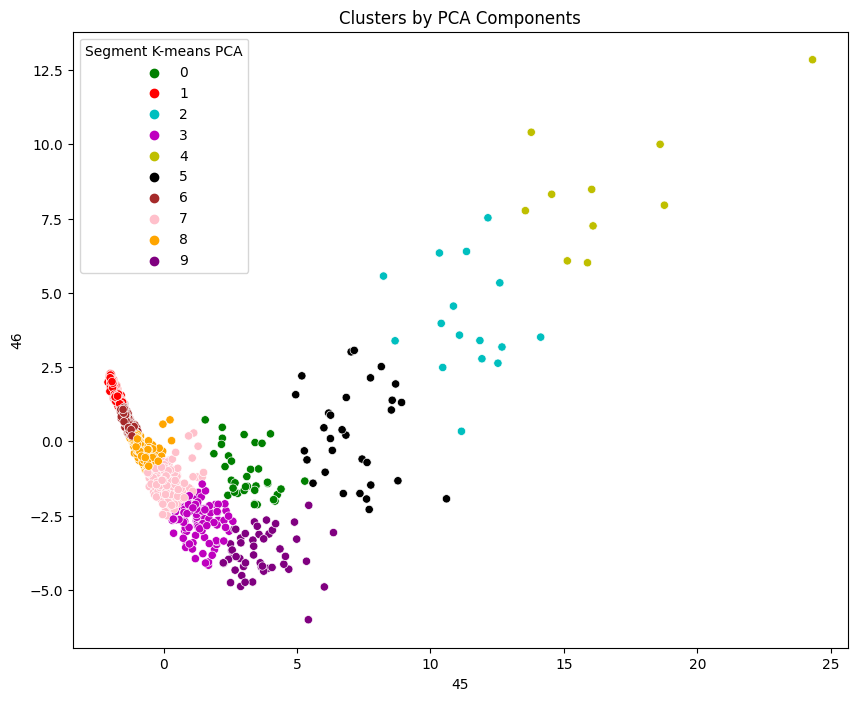

In [35]:
x_axis = df_segm_pca_kmeans[45]
y_axis = df_segm_pca_kmeans[46]
plt.figure(figsize=(10, 8))
sns.scatterplot(x=x_axis, y=y_axis, hue=df_segm_pca_kmeans['Segment K-means PCA'], palette=['g', 'r', 'c', 'm', 'y', 'k', 'brown', 'pink', 'orange', 'purple'])
plt.title('Clusters by PCA Components')
plt.show()

### SVM

In [36]:
from sklearn import svm

In [37]:
clf = svm.SVC(kernel='linear', gamma='auto', decision_function_shape='ovo')
clf.fit(X_train, y_train_class)
y_pred_svm = clf.predict(X_test)

In [38]:
y_pred_svm

array([5, 5, 3, ..., 1, 4, 0])

In [39]:
print(classification_report(y_true=y_test_class, y_pred=y_pred_svm))

              precision    recall  f1-score   support

           0       0.07      0.06      0.06       161
           1       0.17      0.40      0.23       254
           2       0.09      0.04      0.06       138
           3       0.11      0.09      0.10       239
           4       0.15      0.12      0.13       285
           5       0.15      0.21      0.18       315
           6       0.17      0.18      0.17       214
           7       0.14      0.11      0.12       219
           8       0.18      0.11      0.14       299
           9       0.06      0.01      0.02       181

    accuracy                           0.15      2305
   macro avg       0.13      0.13      0.12      2305
weighted avg       0.14      0.15      0.13      2305

